# Chapter 9 - Planning and Learning



### Exercise 9.1

The nonplanning method looks particularly poor in Figure 9.6 because it is a one-step method; a method using eligibility traces would do better. Do you think an eligibility trace method could do as well as the Dyna method? Explain why or why not.

__Answer__: I expect eligibility traces methods to perform generally worse compared to Dyna-Q in this deterministic task (the Dyna Maze), but could be on par under certain conditions. In particular, there are three factors we should consider: the number of backup updates, the magnitude of the updates (controlled by $\alpha$ and $\lambda$) and the coverage of state-action space. Let's take them one by one.

At each step taken in the real environment, Dyna-Q makes $N$ updates via planning, so in total $N T$ updates of the action values table $Q(\cdot, \cdot)$ per episode. Eligibility traces update all previous steps of the episode at each step, so roughly $1 + 2 + ... + T = \dfrac {T(T-1)} {2}$ updates. So for long episodes, when $T > 2N$, eligibility traces seem to have the advantage of making more updates to $Q$ than Dyna.

However, in terms of the magnitude of those updates, for this task where the only non-zero reward is received only by reaching the goal $G$, eligibility traces perform exponentially smaller updates as they move backwards in time, as controlled by the $\lambda$ parameter. So the true values would be slow in propagating back to early states for a small $\lambda$. Compare Figure 7.12 with Figure 9.6. But if $\lambda \approx 1$, the updates should be exactly the same as the planning updates from Dyna.

Finally, we need to keep in mind that the updates in Dyna are randomly chosen from all previous transitions, which means that coverage of the state-action space could be broader early on in Dyna, compared to eligibility traces, which can only update previous steps from the current episode. However, Dyna can also waste large numbers of update steps later on, by randomly choosing them far from the optimal path, whereas eligibility traces would only update states that are closer to the optimal path (due to policy improvement over time).

Given all these reasons, one would expect Dyna methods to perform better than eligibility traces, especially early on, due to faster convergence. But under certain conditions (long episodes and $\lambda$ close to $1$) eligibility traces should be able to match its performance.

### Exercise 9.2

Why did the Dyna agent with exploration bonus, Dyna-Q+, perform better in the first phase as well as in the second phase of the blocking and shortcut experiment?

__Answer__: An exploration bonus nudges the agent towards exploring more than relying on the randomness induced by the $\epsilon$-greedy policy, thus discovering the optimal path faster (as well as accumulating more reward from the bonus itself). This is true both for the inital phase, when the optimal path is found, but even more so in the second phase, when the change in the environment needs a significant amount of exploration in order to find the new optimal paths (this is true for both the blocking and shortcut experiments).

### Exercise 9.3

Careful inspection of Figure 9.8 reveals that the difference between Dyna-Q and Dyna-Q+ narrowed slightly over the first part of the experiment. What is the reason for this?

__Answer__: The advantage of exploration starts to wear out after the optimal path has been found, and exploitation is more rewarding. However in this experiment's setting, the extra bonus for exploration still maintains Dyna-Q+ above Dyna-Q.

### Exercise 9.4

The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Supposed the bonus $\kappa \sqrt{n}$ was used not in backups, but solely in action selection. That is, suppose the action selected was always that for which $Q(s, a) + \kappa \sqrt{n_{sa}}$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.



In [28]:
import math
import matplotlib.pyplot as plt
import random
from itertools import accumulate

%matplotlib inline

In [29]:
class State:
    def __init__(self, row, col):
        self.row = row
        self.col = col

    def __eq__(self, other_state):
        return isinstance(other_state, self.__class__) and self.row == other_state.row and self.col == other_state.col

    def __hash__(self):
        return hash((self.__class__, self.row, self.col))

    def __str__(self):
        return f'({self.row}, {self.col})'


class Action:
    def __init__(self, row, col):
        self.row = row
        self.col = col

    def __eq__(self, other_action):
        return isinstance(other_action, self.__class__) and self.row == other_action.row and self.col == other_action.col

    def __hash__(self):
        return hash((self.__class__, self.row, self.col))

    def __str__(self):
        return f'({self.row}, {self.col})'


class GridWorld:
    def __init__(self, rows, cols, inner_walls, start, goal):
        self.rows = rows
        self.cols = cols
        self.walls = inner_walls  # a set of States
        # add walls all around the grid too
        for row in range(self.rows + 2):
            self.walls.add(State(row, 0))
            self.walls.add(State(row, self.cols + 1))
        for col in range(self.cols + 2):
            self.walls.add(State(0, col))
            self.walls.add(State(self.rows + 1, col))
        self.state = start
        self.goal = goal

    @property
    def is_terminal(self):
        return self.state == self.goal

    def legal_actions(self, s: State = None):
        return [
            Action(1, 0),
            Action(-1, 0),
            Action(0, 1),
            Action(0, -1),
        ]

    def step(self, a: Action):
        next_state = State(self.state.row + a.row, self.state.col + a.col)
        if next_state not in self.walls:
            self.state = next_state
        if self.is_terminal:
            r = 1.
        else:
            r = 0.
        return (self.state, r)

In [30]:
class StateActionValue:
    def __init__(self):
        self.Q = dict()
        self.last_seen = dict()

    # the value(s) of state s and selecting action a (or all)
    def __call__(self, s: State, a: Action = None):
        if s not in self.Q:
            return None
        if a is None:
            # value of all actions from s
            return self.Q[s]
        if a not in self.Q[s]:
            return None
        return self.Q[s][a]

    def update(self, s, a, q, t):
        if s not in self.Q:
            self.Q[s] = dict()
            self.last_seen[s] = dict()
        self.Q[s][a] = q
        self.last_seen[s][a] = t

    def init(self, s, a_list, q=0., t=0):
        if s not in self.Q:
            for a in a_list:
                self.update(s, a, q, t)

    def eps_greedy_policy(self, s: State, current_t, exploration_k=0., eps=0.1):
        a_max = []
        q_max = -999999.
        for a in self.Q[s]:
            if self.Q[s][a] + exploration_k * math.sqrt(current_t - self.last_seen[s][a]) - q_max > 1e-9:
                q_max = self.Q[s][a] + exploration_k * math.sqrt(current_t - self.last_seen[s][a])
                a_max = [a]
            elif abs(self.Q[s][a] + exploration_k * math.sqrt(current_t - self.last_seen[s][a]) - q_max) < 1e-9:
                a_max.append(a)
        random_prob = random.random()
        if random_prob < eps:
            return random.choice(list(self.Q[s].keys()))
        return random.choice(a_max)

In [31]:
class GridWorldModel:
    def __init__(self):
        self.M = dict()

    # the next state and reward
    def __call__(self, s: State, a: Action):
        if s not in self.M:
            return None
        if a not in self.M[s]:
            return None
        return self.M[s][a]

    def update(self, s: State, a: Action, next_s: State, r):
        if s not in self.M:
            self.M[s] = dict()
        self.M[s][a] = (next_s, r)

    def get_random_transition(self):
        s = random.choice(list(self.M.keys()))
        a = random.choice(list(self.M[s].keys()))
        next_s, r = self.M[s][a]
        return (s, a, next_s, r)

In [32]:
class DynaAgent:
    def __init__(self, gamma=0.95, exploration_k=0.01):
        self.gamma = gamma
        self.exploration_k = exploration_k
        self.Q = StateActionValue()
        self.M = GridWorldModel()

    def Q_learning_update(self, env, s, a, next_s, r, alpha, current_t):
        # one step Q-learning for the given transition
        if next_s != env.goal:
            next_a_max = self.Q.eps_greedy_policy(next_s, current_t, self.exploration_k, eps=0)
            new_q = self.Q(s, a) + alpha * (r + self.gamma * self.Q(next_s, next_a_max) - self.Q(s, a))
        else:
            new_q = self.Q(s, a) + alpha * (r - self.Q(s, a))  # value of terminal state = 0 in this game
        # update action values
        self.Q.update(s, a, new_q, current_t)

    """ Generate a single episode for a given environment
        starting from whatever state the environment is in.
        It goes until terminal state or max_steps was reached.
    """
    def play_episode(
            self,
            env: GridWorld,
            start_t=0,
            max_steps=5_000,  # avoid getting stuck forever (e.g. with greedy policies)
            train=False,  # whether to update Q-values (and policy implicitly) during the episode
            learn_model=True,  # whether to update the model of the environment during the episode
            N=0,  # number of planning steps
            epsilon=0.1,  # epsilon for epsilon-greedy policy updates
            alpha=0.1,  # step size for each update of Q-values
            keep_trace=False,  # store a list of tuples for all transitions
        ):
        trace = []
        t = 0  # time steps
        R = 0  # total reward
        s = env.state
        self.Q.init(s, env.legal_actions(s), q=0.)

        while not env.is_terminal and t < max_steps:
            a = self.Q.eps_greedy_policy(s, start_t + t, self.exploration_k, epsilon)
            next_s, r = env.step(a)
            R += r
            if next_s != env.goal:
                self.Q.init(next_s, env.legal_actions(next_s), q=0., t=0)

            if keep_trace:
                trace.append((s, a, r, next_s))

            # update model
            if learn_model:
                self.M.update(s, a, next_s, r)

            # off-policy Q-learning from experience
            if train:
                self.Q_learning_update(env, s, a, next_s, r, alpha, start_t + t)

                # N planning steps from model
                for _ in range(N):
                    random_s, random_a, random_next_s, random_r = self.M.get_random_transition()
                    self.Q_learning_update(env, random_s, random_a, random_next_s, random_r, alpha, start_t + t)

            s = next_s
            t += 1
        return t, R, trace

    def train_controller(self, episodes=100, N=50):
        epsilon = 0.1
        alpha = 0.1
        T_list = [0]
        R_list = [0]
        T = 0
        initial_wall = set([State(4, col) for col in range(1, 9)])
        for e in range(episodes):
            env = GridWorld(
                rows=6,
                cols=9,
                inner_walls=initial_wall,
                start=State(6, 4),
                goal=State(1, 9),
            )
            T, R, _ = self.play_episode(env=env, start_t=T, train=True, learn_model=True, N=N, epsilon=epsilon, alpha=alpha, keep_trace=False)
            T_list.append(T)
            R_list.append(R)
        
        changed_wall = set([State(4, col) for col in range(2, 10)]) # opening opposite
        for e in range(episodes):
            env = GridWorld(
                rows=6,
                cols=9,
                inner_walls=changed_wall,
                start=State(6, 4),
                goal=State(1, 9),
            )
            T, R, _ = self.play_episode(env=env, start_t=T, train=True, learn_model=True, N=N, epsilon=epsilon, alpha=alpha, keep_trace=False)
            T_list.append(T)
            R_list.append(R)

        return T_list, R_list

In [ ]:
agent = DynaAgent(gamma=0.95)
T_list, R_list = agent.train_controller(episodes=50, N=50)

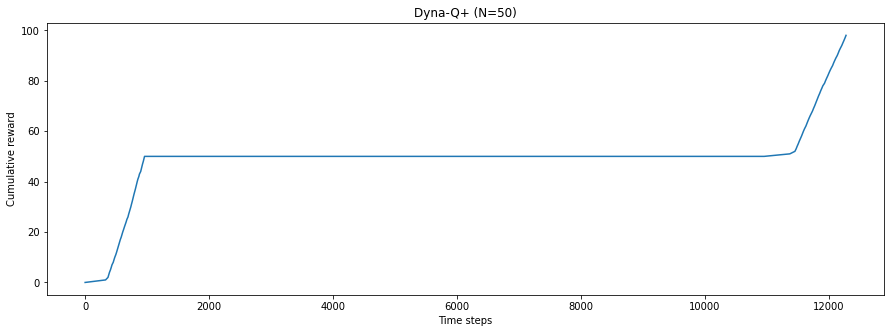

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.plot(list(accumulate(T_list)), list(accumulate(R_list)))
ax.set_xlabel('Time steps')
ax.set_ylabel('Cumulative reward')
ax.set_title('Dyna-Q+ (N=50)')
plt.show()